# phase3 
- phase2 + model paremeter tuning 

In [56]:
import pandas as pd 
import numpy as np 
import datetime as dt
from dateutil.parser import parse

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
import xgboost 
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error

from skopt import BayesSearchCV
from bayes_opt import BayesianOptimization

from tqdm import tqdm


In [57]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

data_info = pd.read_csv('./data/data_info.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [58]:
class LabelEncoderExt(object):
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, data_list):
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [59]:
cat = ['day_of_week','road_name','start_node_name','start_turn_restricted','end_node_name','end_turn_restricted']

In [60]:
le = LabelEncoderExt()

for label in cat: 
    le.fit(train[label]) 
    train[label] = le.transform(train[label])
    test[label] = le.transform(test[label])

In [61]:
train_month = [] 
for i in range(len(train)): 
    train_month.append(int(str(train["base_date"][i])[4:6]))
train["month"] = train_month

test_month = []
for i in range(len(test)):
    test_month.append(int(str(test["base_date"][i])[4:6]))
test["month"] = test_month

In [62]:
#day_of_week 5,6 weekend
train_is_weekend = [] 
for i in range(len(train)): 
    if train["day_of_week"][i] == 5 or train["day_of_week"][i] == 6: 
        train_is_weekend.append(1)
    else: 
        train_is_weekend.append(0)


train["is_weekend"] = train_is_weekend 

test_is_weekend = []
for i in range(len(test)):
    if test["day_of_week"][i] == 5 or test["day_of_week"][i] == 6:
        test_is_weekend.append(1)
    else: 
        test_is_weekend.append(0)

test["is_weekend"] = test_is_weekend

In [63]:
train_is_vacation = [] 
for i in range(len(train)):
    if train["month"][i] == 7 or train["month"][i] == 8: 
        train_is_vacation.append(1)
    else: 
        train_is_vacation.append(0)

train["is_vacation"] = train_is_vacation

test_is_vacation = [] 
for i in range(len(test)): 
    if test["month"][i] == 7 or test["month"][i] == 8:
        test_is_vacation.append(1)
    else: 
        test_is_vacation.append(0)

test["is_vacation"] = test_is_vacation

In [64]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,month,is_weekend,is_vacation
0,TRAIN_0000000,20220623,2,17,1,106,47,0,0,60.0,...,126.662612,1,387,33.427749,126.662335,1,52.0,6,0,0
1,TRAIN_0000001,20220728,2,21,2,103,35,0,0,60.0,...,126.529107,2,2,33.504811,126.526240,1,30.0,7,0,1
2,TRAIN_0000002,20211010,5,7,2,103,37,0,0,80.0,...,126.368598,1,180,33.280072,126.362147,1,61.0,10,1,0
3,TRAIN_0000003,20220311,1,13,2,107,58,0,0,50.0,...,126.567204,1,204,33.245565,126.566228,1,20.0,3,0,0
4,TRAIN_0000004,20211005,7,8,2,103,36,0,0,80.0,...,126.326551,1,270,33.462677,126.330152,1,38.0,10,0,0


In [74]:
train.groupby('month').mean()["target"]

month
1     43.033130
2     43.256182
3     43.548673
5     42.639328
6     42.614157
7     36.282302
9     43.694340
10    43.495717
11    43.728215
12    43.030021
Name: target, dtype: float64

In [67]:
train.groupby('is_weekend').mean()["target"]

is_weekend
0    42.688951
1    43.037119
Name: target, dtype: float64

In [72]:
len(train)

4701217

In [73]:
len(test)

291241

<BarContainer object of 12 artists>

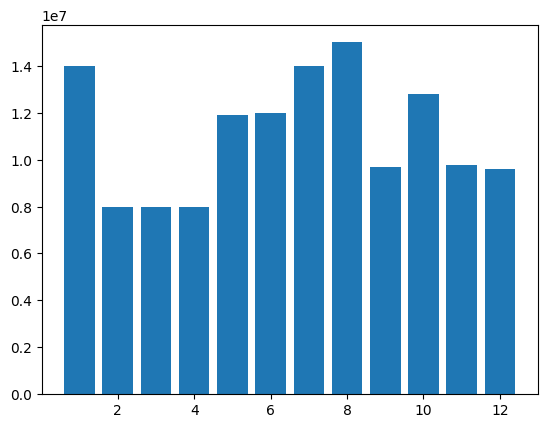

In [71]:
import matplotlib.pyplot as plt
x = [1,2,3,4,5,6,7,8,9,10,11,12]
y = [14000000, 8000100, 8000400, 8000500,11900000,12000000,14005000, 15000300,9700000,12800000,9750000, 9600000 ]
plt.bar(x,y)


In [39]:
all_train_x = train.drop(['id','base_date','target'],axis=1)
all_train_y = train.target

train_x, val_x, train_y, val_y = train_test_split(all_train_x, all_train_y, test_size=0.1, shuffle=True)

test_x = test.drop(['id','base_date'],axis=1)

In [40]:
gb = GradientBoostingRegressor()
gb.fit(train_x,train_y)

GradientBoostingRegressor()

In [41]:
gb_pred_val = gb.predict(val_x)
score = mean_absolute_error(val_y,gb_pred_val)

In [42]:
print(score)

6.490636814689503


In [44]:
gb.fit(all_train_x,all_train_y)

GradientBoostingRegressor()

In [45]:
gb_pred_test = gb.predict(test_x)

In [46]:
gb_pred_test

array([24.21877806, 44.94374286, 56.10505958, ..., 21.50792447,
       28.73108996, 35.07354722])

In [47]:
phase2_gb = sample_submission.copy()
phase2_gb['target'] = gb_pred_test
phase2_gb.to_csv("./submissions/phase2_gb.csv", index = False)


In [48]:
def get_scores(models,train_x,train_y, test_x, test_y):
    scores = {}
    for model in tqdm(models): 
        model.fit(train_x, train_y)
        pred = model.predict(test_x)
        score = mean_absolute_error(test_y,pred)
        scores[str(model)] = score 

    return scores

In [17]:
rf = RandomForestRegressor() 
lgbm = LGBMRegressor() 
xgb = XGBRegressor()
cat = CatBoostRegressor() 

models = [rf, lgbm, xgb, cat]


In [20]:
val_scores = get_scores(models, train_x, train_y, val_x, val_y)

 75%|███████▌  | 3/4 [29:12<06:37, 397.91s/it]   

Learning rate set to 0.153165
0:	learn: 14.6316493	total: 368ms	remaining: 6m 7s
1:	learn: 13.5872093	total: 592ms	remaining: 4m 55s
2:	learn: 12.7724261	total: 842ms	remaining: 4m 39s
3:	learn: 12.1290871	total: 1.09s	remaining: 4m 31s
4:	learn: 11.6174084	total: 1.29s	remaining: 4m 17s
5:	learn: 11.1852001	total: 1.48s	remaining: 4m 5s
6:	learn: 10.8620252	total: 1.65s	remaining: 3m 54s
7:	learn: 10.5548619	total: 1.84s	remaining: 3m 48s
8:	learn: 10.3284909	total: 2.01s	remaining: 3m 41s
9:	learn: 10.1003987	total: 2.22s	remaining: 3m 40s
10:	learn: 9.8990515	total: 2.4s	remaining: 3m 36s
11:	learn: 9.7085320	total: 2.61s	remaining: 3m 35s
12:	learn: 9.5644732	total: 2.83s	remaining: 3m 34s
13:	learn: 9.4611201	total: 3.03s	remaining: 3m 33s
14:	learn: 9.3291009	total: 3.24s	remaining: 3m 32s
15:	learn: 9.2255966	total: 3.48s	remaining: 3m 33s
16:	learn: 9.1476649	total: 3.67s	remaining: 3m 32s
17:	learn: 9.0738627	total: 3.89s	remaining: 3m 32s
18:	learn: 9.0096434	total: 4.1s	rema

100%|██████████| 4/4 [32:36<00:00, 489.07s/it]

999:	learn: 5.0373136	total: 3m 22s	remaining: 0us


In [21]:
val_scores

{'RandomForestRegressor()': 3.3240952770011924,
 'LGBMRegressor()': 4.666367932363044,
 "XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,\n             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n             early_stopping_rounds=None, enable_categorical=False,\n             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',\n             importance_type=None, interaction_constraints='',\n             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,\n             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,\n             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,\n             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,\n             reg_lambda=1, ...)": 3.84221665298861,
 '<catboost.core.CatBoostRegressor object at 0x0000019821534348>': 3.6310288356187477}

In [30]:
rf.fit(all_train_x,all_train_y)
lgbm.fit(all_train_x,all_train_y)
xgb.fit(all_train_x,all_train_y)
cat.fit(all_train_x,all_train_y) 

KeyboardInterrupt: 

In [29]:
all_train_x

,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,...,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,month,is_weekend,is_vacation
0,2,17,1,106,47,0,0,60.0,0.0,32400.0,...,33.427747,126.662612,1,387,33.427749,126.662335,1,6,0,0
1,2,21,2,103,35,0,0,60.0,0.0,0.0,...,33.500730,126.529107,2,2,33.504811,126.526240,1,7,0,1
2,5,7,2,103,37,0,0,80.0,0.0,0.0,...,33.279145,126.368598,1,180,33.280072,126.362147,1,10,1,0
3,1,13,2,107,58,0,0,50.0,0.0,0.0,...,33.246081,126.567204,1,204,33.245565,126.566228,1,3,0,0
4,7,8,2,103,36,0,0,80.0,0.0,0.0,...,33.462214,126.326551,1,270,33.462677,126.330152,1,10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,2,16,1,107,0,0,0,50.0,0.0,0.0,...,33.422145,126.278125,1,43,33.420955,126.273750,1,11,0,0
4701213,2,2,2,107,0,0,0,80.0,0.0,43200.0,...,33.472505,126.424368,1,32,33.472525,126.424890,1,3,0,0
4701214,4,22,2,103,36,0,0,60.0,0.0,0.0,...,33.447183,126.912579,1,215,33.444121,126.912948,1,6,0,0
4701215,3,2,2,103,38,0,0,80.0,0.0,0.0,...,33.443596,126.431817,1,24,33.444996,126.433332,1,10,0,0


In [35]:
rf_pred_test = rf.predict(test_x)
lgmb_pred_test = lgbm.predict(test_x)
xgb_pred_test = xgb.predict(test_x)
#cat_pred_test = cat.predict(test)

c:\Users\CHA SOOBIN\Anaconda3\envs\main_env\lib\site-packages\sklearn\ensemble\_forest.py:993: RuntimeWarning: invalid value encountered in true_divide
  y_hat /= len(self.estimators_)


In [55]:
#weighted averge ensemble 
weighted_ensemble = sample_submission.copy()

rf = pd.read_csv('./submissions/phase2_rf.csv')
rf_pred = rf.target
xgb = pd.read_csv('./submissions/baseline_xgb.csv')
xgb_pred = xgb.target

weighted_average = ((rf_pred * 0.6) + (xgb_pred * 0.4)) 

weighted_ensemble["target"] = weighted_average

weighted_ensemble.to_csv("./submissions/rf(0.6)_xgb(0.4)_weighted.csv", index = False)


In [51]:
rf.head()

,id,target
0,TEST_000000,25.82
1,TEST_000001,40.58
2,TEST_000002,67.10
3,TEST_000003,38.07
4,TEST_000004,42.89
